In [2]:
import sys

# adding Folder_2 to the system path
#sys.path.insert(0, '/Users/lisadang/Desktop/Github/SPCA')

import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit


In [29]:
eclipse = ['3']
aperture = ['5']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {a: [] for a in aperture}
aplev_arr = {a: [] for a in aperture}
aperr_arr = {a: [] for a in aperture}
centroid_x_arr = {a: [] for a in aperture}
centroid_y_arr = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        if eclipse[0] == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[a] = np.append(time_arr[a], np.array(file['time']))
            aplev_arr[a] = np.append(aplev_arr[a], np.array(file['aplev']))
            aperr_arr[a] = np.append(aperr_arr[a], np.array(file['aperr']))
            centroid_x_arr[a] = np.append(centroid_x_arr[a], np.array(file['centroid_x']))
            centroid_y_arr[a] = np.append(centroid_y_arr[a], np.array(file['centroid_y']))

    time_arr[a] = np.array(time_arr[a])
    aplev_arr[a] = np.array(aplev_arr[a])
    aperr_arr[a] = np.array(aperr_arr[a])
    centroid_x_arr[a] = np.array(centroid_x_arr[a])
    centroid_y_arr[a] = np.array(centroid_y_arr[a])
    
print(time_arr['5'])

[60510.00890112 60510.0090294  60510.00915768 ... 60510.17040581
 60510.17053409 60510.17066237]


In [30]:
time = time_arr['5']
aplev = aplev_arr['5']
aperr = aperr_arr['5']
centroid_x = centroid_x_arr['5']
centroid_y = centroid_y_arr['5']

aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

In [8]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

## ECLIPSE 3

Text(0.5, 1.0, 'LHS 1140c Eclipse 3')

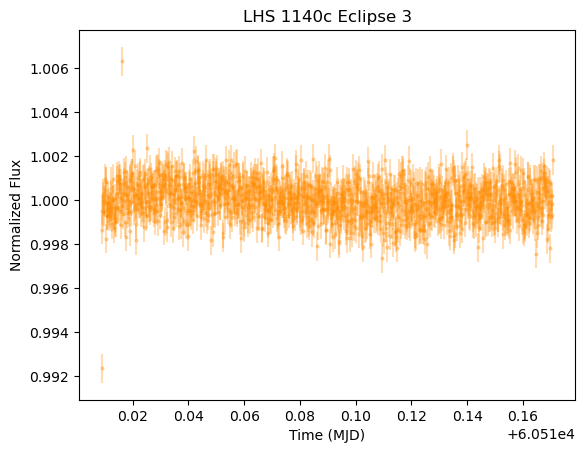

In [32]:
plt.errorbar(time, aplev, yerr=aperr, color='darkorange',markersize=2, alpha=0.3, fmt='o')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalized Flux')
plt.title('LHS 1140c Eclipse 3')

In [33]:
nbin = 100
ndiscard = 2 # removes ... mins

# remove more points to get the ramp out...
bins_time, binErr_t = binValues(time[ndiscard:], time[ndiscard:], nbin)
bins_aplev, binErr_aplev = binValues(aplev[ndiscard:], time[ndiscard:], nbin)
bins_aperr, binErr_aperr = binValues(aperr[ndiscard:], time[ndiscard:], nbin)
bins_centroid_x, binErr_centroid_x = binValues(centroid_x[ndiscard:], time[ndiscard:], nbin)
bins_centroid_y, binErr_centroid_y = binValues(centroid_y[ndiscard:], time[ndiscard:], nbin)

# unibnned
#ndiscard = 100
time = time[ndiscard:]
aplev = aplev[ndiscard:]
aperr = aperr[ndiscard:]
centroid_x = centroid_x[ndiscard:]
centroid_y = centroid_y[ndiscard:]

Text(0, 0.5, 'Normalized Flux')

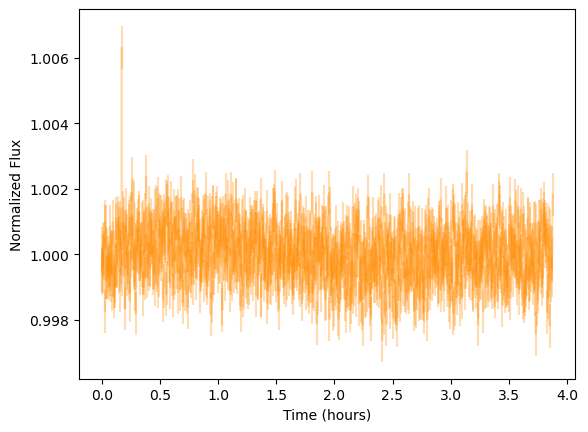

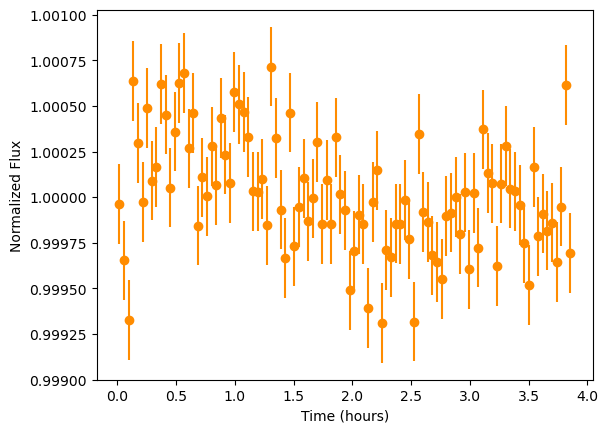

In [34]:
plt.figure()
plt.errorbar((time-time[0])*(24), aplev, yerr=aperr, alpha=0.3, color='darkorange')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
#plt.ylim(0.996, 1.0045)
plt.figure()
plt.errorbar((bins_time-time[0])*(24), bins_aplev, yerr=binErr_aplev, fmt='o', color='darkorange')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
#plt.ylim(0.996, 1.0045)


In [35]:
# remove eclipse pts from binned
#eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
t_s = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')
eclipse = t_s.mjd 
transit = Time('2458389.293900', format = 'jd', scale = 'tdb')
transit = transit.mjd
print(eclipse, transit)

e_dur_days = 1.13 / 24
start = eclipse - (e_dur_days / 2)  # Center the rectangle at the start of the eclipse

# from binned data
ind1 = np.abs(bins_time - start).argmin()
ind2 = np.abs(bins_time - (start + e_dur_days)).argmin()
bins_time = np.delete(bins_time, np.arange(ind1,ind2))
bins_aplev = np.delete(bins_aplev, np.arange(ind1,ind2))
bins_aperr = np.delete(bins_aperr, np.arange(ind1,ind2))

60510.106944444444 58388.7939


<ErrorbarContainer object of 3 artists>

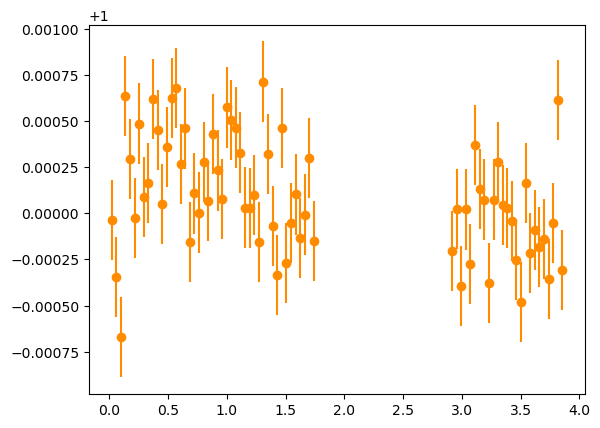

In [36]:
# plot binned data without eclipse
plt.figure()
plt.errorbar((bins_time-time[0])*(24), bins_aplev, yerr=binErr_aplev, fmt='o', color='darkorange')

# center the time array before binning !!!

In [37]:
exp_bins_time = (bins_time-time[0])*(24)
exp_time = (time-time[0])*(24)

5.734895061096462e-05 -0.0003312133992833888 0.0004085577908727154 1.0000901143792549


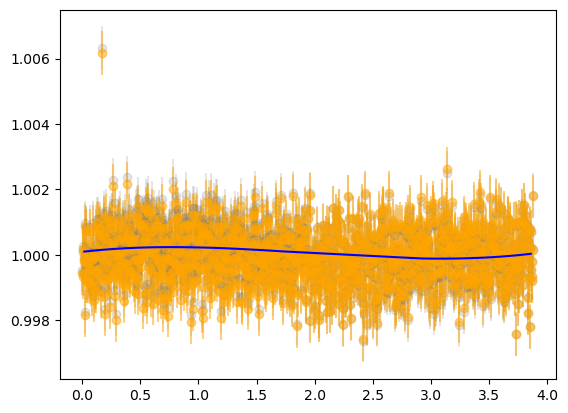

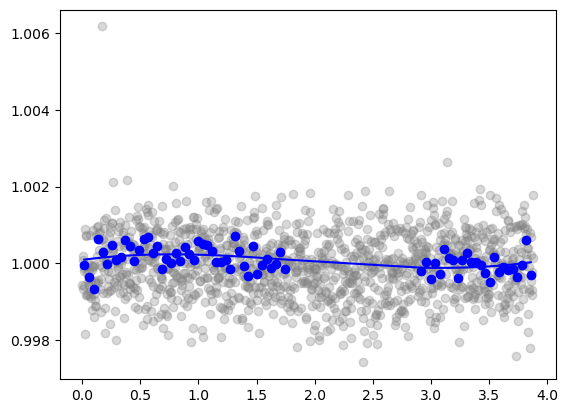

In [235]:
def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

# Use curve_fit to fit the polynomial to your data
params, covariance = curve_fit(poly_3rd_degree, exp_bins_time, bins_aplev)

# Extract the fitted parameters
a, b, c, d = params
print(a, b, c, d)
# Generate the fitted curve using the parameters
fitted_curve = poly_3rd_degree(exp_bins_time, a, b, c, d)

# Plot the data with error bars
plt.errorbar(exp_time, aplev, yerr=aperr, label='Data', color='grey', marker='o', linestyle='', alpha=0.2)
plt.errorbar(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d), yerr=aperr, label='Data', color='orange', marker='o', linestyle='', alpha=0.5)
plt.plot(exp_bins_time, fitted_curve, label='Fitted curve', color='blue', zorder=3)

plt.figure()
plt.plot(exp_bins_time, bins_aplev, 'o', label='Binned data', color='blue')
plt.plot(exp_bins_time, fitted_curve, label='Fitted curve', color='blue')
plt.plot(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d),  'o', label='Binned data', color='grey', alpha=0.3, zorder=1)


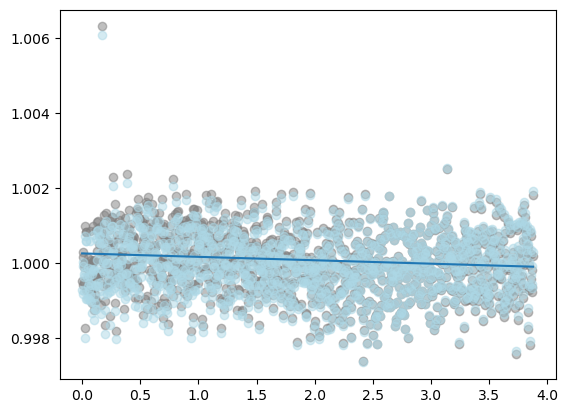

In [29]:
plt.scatter(exp_time, aplev, alpha=0.5, color='grey')
plt.scatter(exp_time, aplev/exponential_func(exp_time, a, b, c), alpha=0.5, color='lightblue')
plt.plot(exp_time, exponential_func(exp_time, a, b, c))

In [18]:
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c


#initial_guess = [1e6, 1, 1e6] 
# Fit the exponential function to the data
params, covariance = curve_fit(exponential_func, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b, c = params
print(a,b,c)

0.284437766861067 0.0003218453369957566 0.7158164845760568


-9.149007156294964e-05 1.0002542252366127


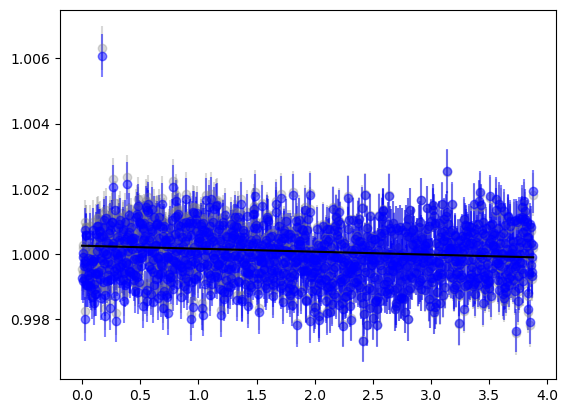

In [38]:
# linear

def linear_slope(time, m, b):
    return m*time + b

params, covariance = curve_fit(linear_slope, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b = params
print(a,b)

plt.errorbar(exp_time, aplev, yerr=aperr, marker='o',color='grey',linestyle='', alpha=0.3)
plt.errorbar(exp_time, aplev/linear_slope(exp_time, a, b), yerr=aperr, marker='o',color='blue',linestyle='', alpha=0.5, zorder=2)
plt.plot(exp_time, linear_slope(exp_time, a, b), color='black', zorder=3)

0.5004678884224679 8.85810611063483e-05 0.4997863478353875 9.439266711947797e-05


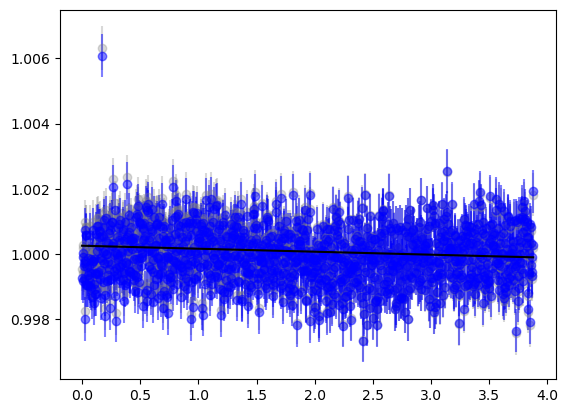

In [39]:
# double exponential doesnt work
def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

params, covariance = curve_fit(double_exponential, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b, c, d = params
print(a,b,c,d)

plt.errorbar(exp_time, aplev, yerr=aperr, marker='o',color='grey',linestyle='', alpha=0.3)
plt.errorbar(exp_time, aplev/double_exponential(exp_time, a, b, c, d), yerr=aperr, marker='o',color='blue',linestyle='', alpha=0.5, zorder=2)
plt.plot(exp_time, double_exponential(exp_time, a, b, c, d), color='black', zorder=3)

## ECLIPSE 2

Text(0.5, 1.0, 'LHS 1140c Eclipse 2')

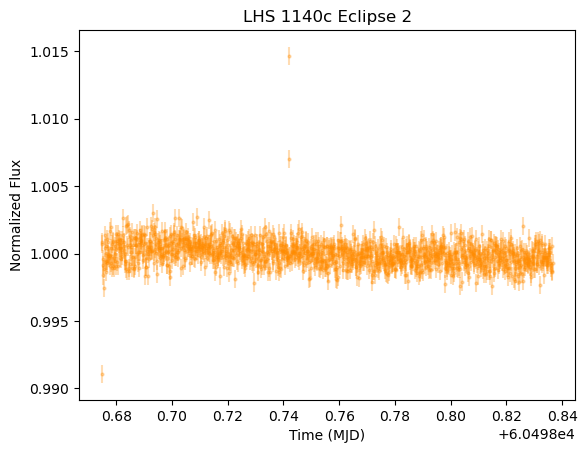

In [10]:
plt.errorbar(time, aplev, yerr=aperr, color='darkorange',markersize=2, alpha=0.3, fmt='o')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalized Flux')
plt.title('LHS 1140c Eclipse 2')

In [11]:
nbin = 100
ndiscard = 2 # removes ... mins

# remove more points to get the ramp out...
bins_time, binErr_t = binValues(time[ndiscard:], time[ndiscard:], nbin)
bins_aplev, binErr_aplev = binValues(aplev[ndiscard:], time[ndiscard:], nbin)
bins_aperr, binErr_aperr = binValues(aperr[ndiscard:], time[ndiscard:], nbin)
bins_centroid_x, binErr_centroid_x = binValues(centroid_x[ndiscard:], time[ndiscard:], nbin)
bins_centroid_y, binErr_centroid_y = binValues(centroid_y[ndiscard:], time[ndiscard:], nbin)

# unibnned
#ndiscard = 100
time = time[ndiscard:]
aplev = aplev[ndiscard:]
aperr = aperr[ndiscard:]
centroid_x = centroid_x[ndiscard:]
centroid_y = centroid_y[ndiscard:]

Text(0, 0.5, 'Normalized Flux')

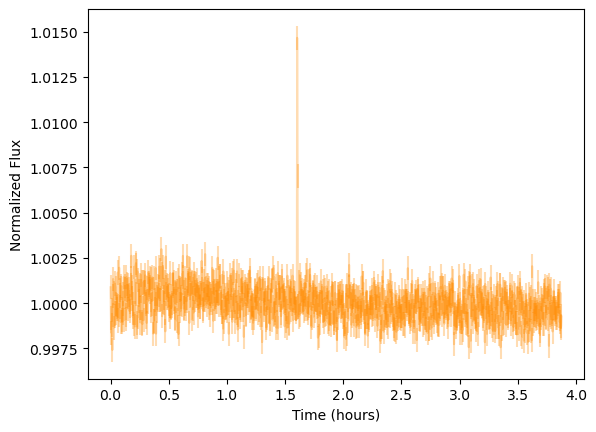

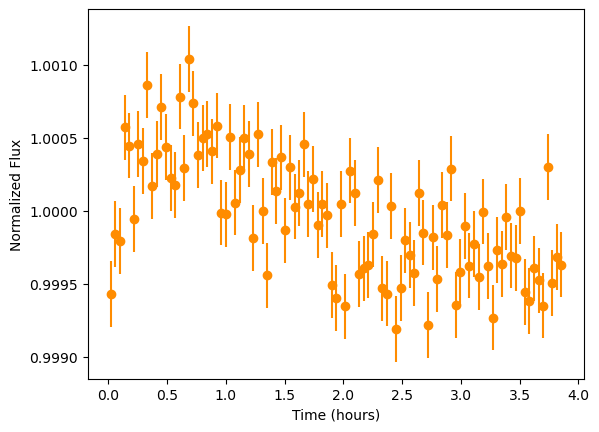

In [12]:
plt.figure()
plt.errorbar((time-time[0])*(24), aplev, yerr=aperr, alpha=0.3, color='darkorange')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
#plt.ylim(0.996, 1.0045)
plt.figure()
plt.errorbar((bins_time-time[0])*(24), bins_aplev, yerr=binErr_aplev, fmt='o', color='darkorange')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')
#plt.ylim(0.996, 1.0045)

In [13]:
# remove eclipse pts from binned
#eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
t_s = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
eclipse = t_s.mjd 
transit = Time('2458389.293900', format = 'jd', scale = 'tdb')
transit = transit.mjd
print(eclipse, transit)

e_dur_days = 1.13 / 24
start = eclipse - (e_dur_days / 2)  # Center the rectangle at the start of the eclipse

# from binned data
ind1 = np.abs(bins_time - start).argmin()
ind2 = np.abs(bins_time - (start + e_dur_days)).argmin()
bins_time = np.delete(bins_time, np.arange(ind1,ind2))
bins_aplev = np.delete(bins_aplev, np.arange(ind1,ind2))
bins_aperr = np.delete(bins_aperr, np.arange(ind1,ind2))

60498.77361111111 58388.7939


<ErrorbarContainer object of 3 artists>

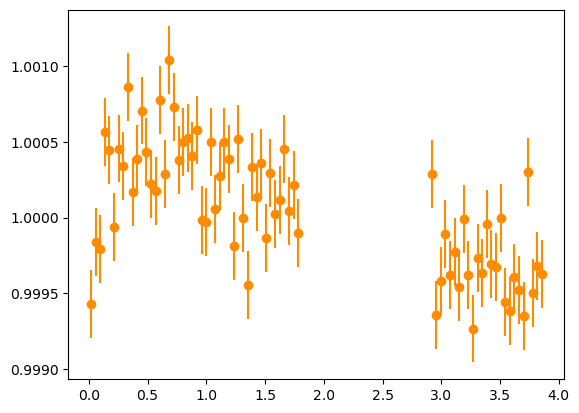

In [14]:
plt.figure()
plt.errorbar((bins_time-time[0])*(24), bins_aplev, yerr=binErr_aplev, fmt='o', color='darkorange')

In [15]:
exp_bins_time = (bins_time-time[0])*(24)
exp_time = (time-time[0])*(24)

[ 9.05030776e-05 -5.54250578e-04  6.96441578e-04  1.00011736e+00]


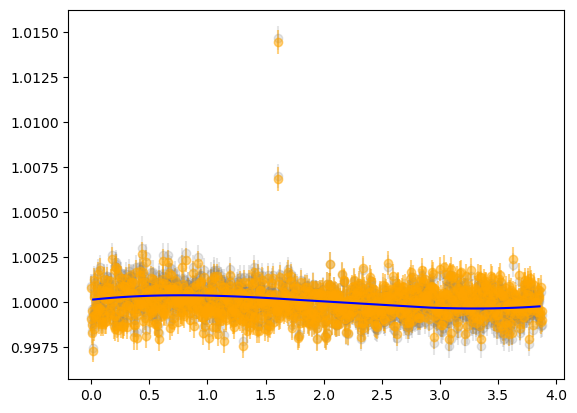

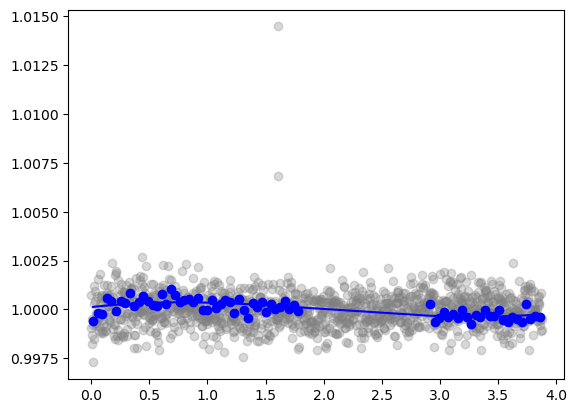

In [16]:
def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

# Use curve_fit to fit the polynomial to your data
params, covariance = curve_fit(poly_3rd_degree, exp_bins_time, bins_aplev)

# Extract the fitted parameters
a, b, c, d = params
print(params)

# Generate the fitted curve using the parameters
fitted_curve = poly_3rd_degree(exp_bins_time, a, b, c, d)

# Plot the data with error bars
plt.errorbar(exp_time, aplev, yerr=aperr, label='Data', color='grey', marker='o', linestyle='', alpha=0.2)
plt.errorbar(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d), yerr=aperr, label='Data', color='orange', marker='o', linestyle='', alpha=0.5)
plt.plot(exp_bins_time, fitted_curve, label='Fitted curve', color='blue', zorder=3)

plt.figure()
plt.plot(exp_bins_time, bins_aplev, 'o', label='Binned data', color='blue')
plt.plot(exp_bins_time, fitted_curve, label='Fitted curve', color='blue')
plt.plot(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d),  'o', label='Binned data', color='grey', alpha=0.3, zorder=1)


0.9442588023676416 0.00023172786914537203 0.056190963345282764


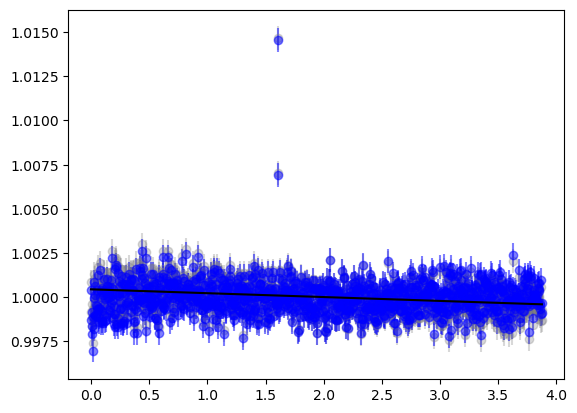

In [25]:
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the exponential function to the data
params, covariance = curve_fit(exponential_func, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b, c = params
print(a,b,c)

plt.errorbar(exp_time, aplev, yerr=aperr, marker='o',color='grey',linestyle='', alpha=0.3)
plt.errorbar(exp_time, aplev/exponential_func(exp_time, a, b, c), yerr=aperr, marker='o',color='blue',linestyle='', alpha=0.5, zorder=2)
plt.plot(exp_time, exponential_func(exp_time, a, b, c), color='black', zorder=3)

-0.00021872009640224572 1.0004497232626075


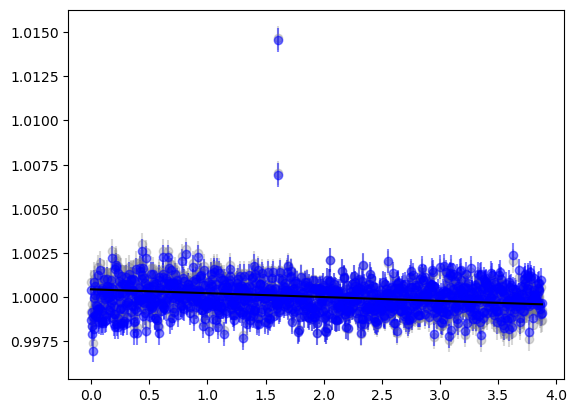

In [27]:
# linear

def linear_slope(time, m, b):
    return m*time + b

params, covariance = curve_fit(linear_slope, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b = params
print(a,b)

plt.errorbar(exp_time, aplev, yerr=aperr, marker='o',color='grey',linestyle='', alpha=0.3)
plt.errorbar(exp_time, aplev/linear_slope(exp_time, a, b), yerr=aperr, marker='o',color='blue',linestyle='', alpha=0.5, zorder=2)
plt.plot(exp_time, linear_slope(exp_time, a, b), color='black', zorder=3)

In [28]:
# double exponential doesnt work
def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

params, covariance = curve_fit(double_exponential, exp_bins_time, bins_aplev)

# Extract the fitting parameters
a, b, c, d = params
print(a,b,c,d)

plt.errorbar(exp_time, aplev, yerr=aperr, marker='o',color='grey',linestyle='', alpha=0.3)
plt.errorbar(exp_time, aplev/double_exponential(exp_time, a, b, c, d), yerr=aperr, marker='o',color='blue',linestyle='', alpha=0.5, zorder=2)
plt.plot(exp_time, double_exponential(exp_time, a, b, c, d), color='black', zorder=3)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [193]:
def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):

    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def signal(time, xdata, ydata, t_s, fp, c1, c2, c3, c4, c5, c6):

    astro = transit_model(time, t_s, fp)
    detec = detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6)

    return astro*detec


In [194]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = -50637.141394331586 #58388.7939*24               #time of inferior conjunction
    params.per = 3.777940*24                 #orbital period
    params.rp = 0.0539                   #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

In [211]:
#t_s = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
#t_s = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')
#t_s = t_s.mjd 
# eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
# eclipse = eclipse.mjd
# print(eclipse)
# t_s = 60275.875 # e3 60510.106944444444 #60498.77361111111 e2 # e1 # CHANGE IN PRIOR AS WELL
# fp = 0.000230
e_dur = 1.13 # hours
e_dur_days = 1.13 / 24

# eclipse 2
#t_s = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
t_s = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb') # eclipse 3
eclipse = t_s.mjd 
eclipse = (eclipse - time_arr['5'][0])*24

transit = Time('2458389.293900', format = 'jd', scale = 'tdb')
transit = transit.mjd
transit = (transit - time_arr['5'][0])*24
print(eclipse, transit)
fp = 0.000230

p0_astro = np.array([eclipse, fp]) 
p0_detec = np.array([0.5, 0.1, 0.1, -0.1, 0.1, 0.1])

2.3716723350808024 -50637.141394331586


In [77]:
print(t_s)

60275.875


In [196]:
def log_likelihood(theta, time, flux, xdata, ydata):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta

    model = signal(time, xdata, ydata, t_s, fp, c1, c2, c3, c4, c5, c6)
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta

    # gaussian prior
    prior = 0.
    #prior -= 0.5 * (((t_s - 60275.875) / 0.000040) ** 2.)

    # uniform prior
    if (0 < fp < 1 and (eclipse-(e_dur/2)) < t_s < (eclipse+(e_dur/2)) and sigF > 0.): 
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux, xdata, ydata):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, xdata, ydata)

In [198]:
p0 = np.concatenate((p0_astro, p0_detec, [0.001]))
nsteps, nwalkers, ndim = 10000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y)) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d), centroid_x, centroid_y))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(bins_time, bins_aplev/exponential_func(bins_time, a, b, c), centroid_x, centroid_y))
pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [01:44<00:00, 95.43it/s]


In [199]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

In [200]:
#Saving MCMC Results
savepath = 'MCMC_exp/e3_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

# Load MCMC results
#load previous MCMC results
# pathchain = 'MCMC_exp/samplerchain_10000.npy'
# pathlnlchain = 'MCMC_exp/samplerlnlchain_10000.npy'
# pathposit = 'MCMC_exp/samplerposi_10000.npy'
# pathlnpro = 'MCMC_exp/samplerlnpr_10000.npy'
# chain = np.load(pathchain)
# lnprobchain = np.load(pathlnlchain)
# pos2 = np.load(pathposit)
# prob = np.load(pathlnpro)

In [201]:
ndim = 9
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)

MCMC result:

     t_s = 2.2580016100088143  +0.04200533332750389  -0.14788046768230645
      fp = 0.0002518489191306151  +5.41825830558301e-05  -5.464646712948591e-05
     c_1 = 138233.72659255876  +83960.70819389715  -82966.4377920311
     c_2 = -967.1643601556088  +907.5762891295366  -933.9464038674009
     c_3 = -1232.7230349690558  +651.5476094006328  -643.7049121886621
     c_4 = 0.45518835858403817  +3.0222757673344463  -2.98264911075056
     c_5 = 6.785118397243043  +3.2656189172874104  -3.2730268246104224
     c_6 = 1.5121512239130033  +1.7387421606874756  -1.7554215131274866
    sigF = 0.0008232461230090961  +1.6950194517346734e-05  -1.6171911493971275e-05



In [150]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
print(np.abs(eclipse-t_s)*60)

5.500279447573302


In [152]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    """Make a plot showing the evolution of the walkers throughout the emcee sampling.
    Args:
        chain (ndarray): The ndarray accessed by calling sampler.chain when using emcee
        labels (ndarray): The fancy labels for each dimension
        interv (int): Take every 'interv' element to thin out the plot
        name (string, optional): The savepath for the plot (or None if you want to return the figure instead).
        showPlot (bool, optional): Whether or not you want to show the plotted figure.
    Returns:
        None

    """

    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

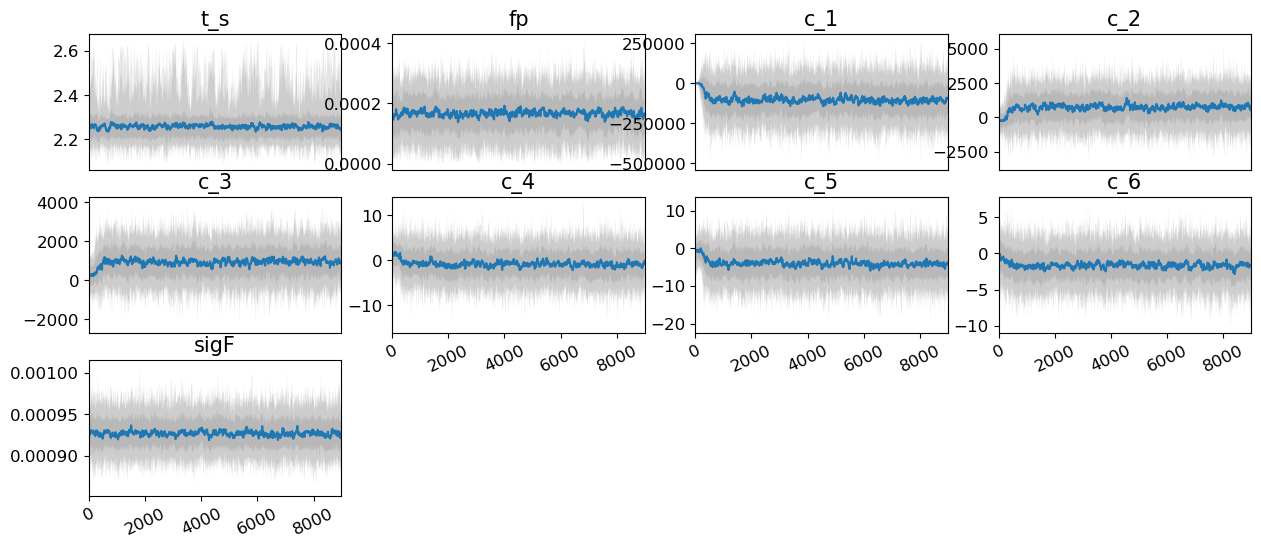

In [153]:
#walk_style(chain, p0_labels, interv=10, showPlot=True, fontsize=15)
walk_style(chain, p0_labels, interv=10, fname='MCMC_exp/walkers_100000.png', showPlot=True, fontsize=15)

In [57]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

labels = [r'$t_{s}$', r'$f_{p}$', r'$c_1$', r'$c_2$', r'$c_3$', r'$c_4$', r'$c_5$', r'$c_6$', r'$\sigma _F$']

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('MCMC_exp/corner_10000.png')
plt.close()

In [214]:
def plot_bestfit(time, flux, astro, detec, eclipse, t_s, e_dur, showPlot=True, fontsize=24):
    
    x = time
    
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 14))
    
    axes[0].set_xlim(np.nanmin(x), np.nanmax(x))
    axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[0].plot(x, astro*detec, '.', color = 'r', markersize = 2.5, alpha = 0.4)
    axes[0].set_ylabel('Raw Flux', fontsize=fontsize)

    axes[1].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[1].plot(x, astro, color = 'r', linewidth=2)
    axes[1].set_ylabel('Calibrated Flux', fontsize=fontsize)
    
    axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
    axes[2].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[2].plot(x, astro, color = 'red', linewidth=2)
    
    axes[1].axvline(x = eclipse, color='g', linewidth = 2) #60275.875 e1
    axes[1].axvline(x = eclipse+e_dur/2, color='g', linewidth = 2, label='expected')
    axes[1].axvline(x = eclipse-e_dur/2, color='g', linewidth = 2)
    axes[1].axvline(x = t_s, color='r', linewidth = 2, label='t_s')
    axes[1].legend()

    axes[2].set_ylabel('Calibrated Flux', fontsize=fontsize)
    axes[2].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))

    axes[3].plot(x, flux/detec - astro, 'k.', markersize = 4, alpha = 0.15)
    axes[3].axhline(y=0, color='r', linewidth = 2)
    print(np.std(flux/detec - astro))


    axes[3].set_ylabel('Residuals', fontsize=fontsize)
    axes[3].set_xlabel('Time (BMJD)', fontsize=fontsize)

    
    fig.align_ylabels()
    fig.subplots_adjust(hspace=0)
    fig.savefig('MCMC_exp/bestfit_e2.png')
        
    if showPlot:
        plt.show()
    
    plt.close()
    return

0.0008224568724334824


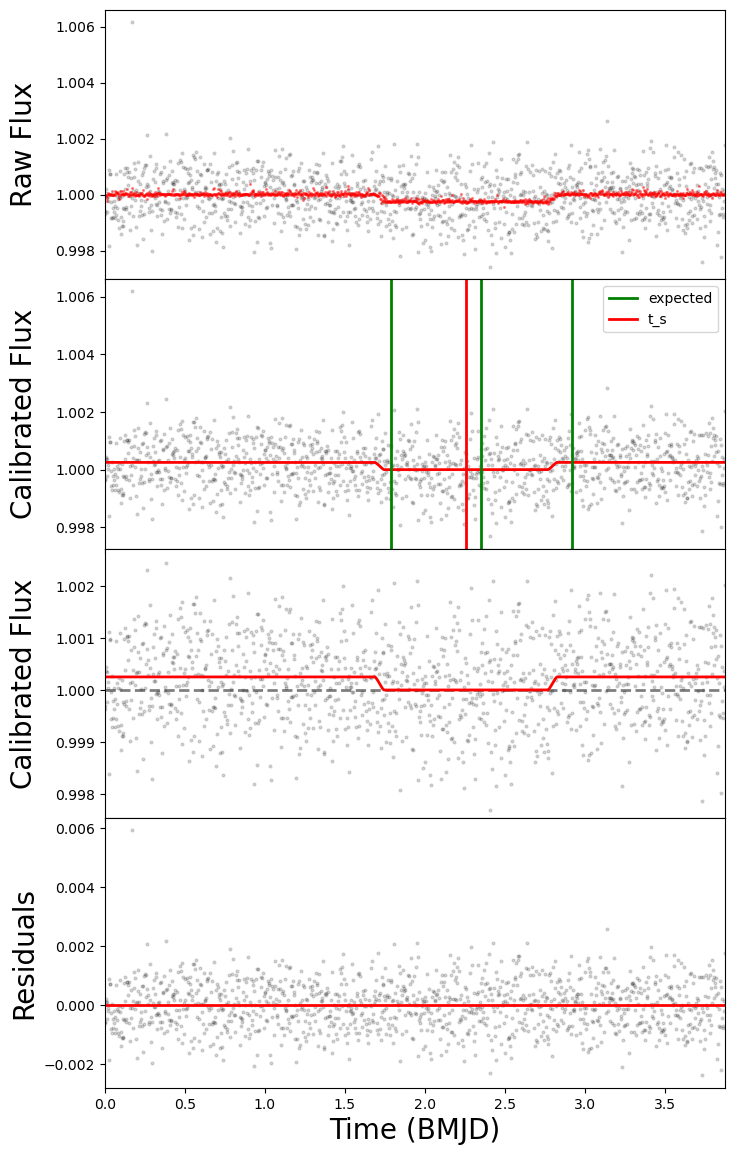

5.702286339785854


In [205]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(exp_time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
plot_bestfit(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d), astro, detec, eclipse, t_s, e_dur, showPlot=True, fontsize=20)
#plot_bestfit(time, aplev, astro, detec, showPlot=True, fontsize=20)

print((2.353039715671912-t_s)*60)

In [206]:
pathchain = 'MCMC_exp/e2_samplerchain_10000.npy'
pathlnlchain = 'MCMC_exp/e2_samplerlnlchain_10000.npy'
pathposit = 'MCMC_exp/e2_samplerposi_10000.npy'
pathlnpro = 'MCMC_exp/e2_samplerlnpr_10000.npy'
chain = np.load(pathchain)
lnprobchain = np.load(pathlnlchain)
pos2 = np.load(pathposit)
prob = np.load(pathlnpro)

In [207]:
ndim = 9
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)

MCMC result:

     t_s = 2.2800010109545807  +0.04878116794550991  -0.055475988074118465
      fp = 0.00018567610133979405  +6.0429095866791204e-05  -6.303828491350505e-05
     c_1 = -91556.34053238806  +100752.49511087615  -104600.26283431171
     c_2 = 642.266233415557  +1069.8912622211906  -1047.5583399560367
     c_3 = 811.9867559562965  +800.0525894438028  -805.960921047136
     c_4 = -0.7819083193390751  +3.1512537899469217  -3.215122301670056
     c_5 = -3.5396570334680164  +4.072533294855089  -4.101092097806179
     c_6 = -1.4530938395093846  +2.1435849742232254  -2.1368678500770613
    sigF = 0.0009197981603145913  +1.8826120557879542e-05  -1.80445353113953e-05



In [226]:
print(0.0487*60)

2.922


0.0009233270621293321


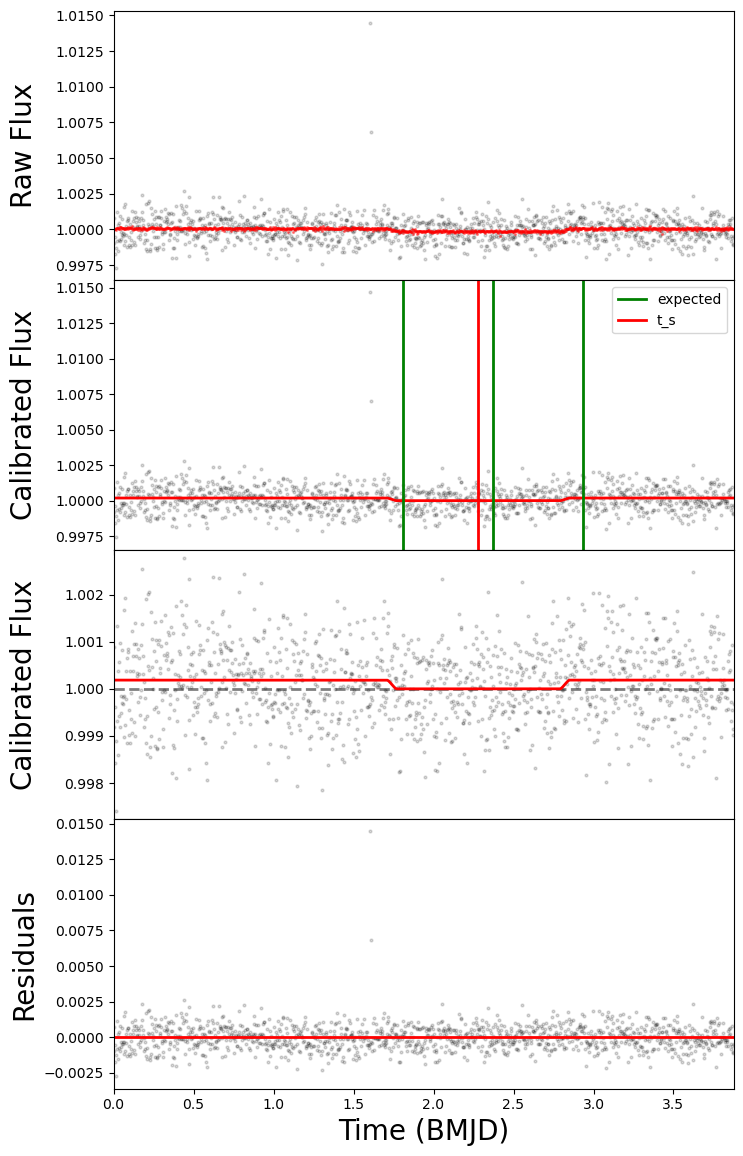

5.500279447573302


In [225]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
# a, b, c, d = 9.05030776e-05 -5.54250578e-04  6.96441578e-04  1.00011736e+00
astro = transit_model(exp_time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
plot_bestfit(exp_time, aplev/poly_3rd_degree(exp_time, a, b, c, d), astro, detec, 2.3716723350808024, t_s, e_dur, showPlot=True, fontsize=20)

print((2.3716723350808024-t_s)*60)

In [115]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.savefig('MCMC_eclipse2/MCMC_RedNoise.png')

    if showPlot:
        plt.show()
    
    plt.close()

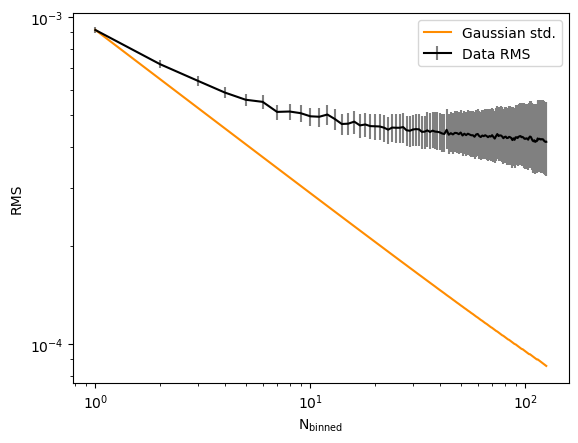

In [116]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
residuals = ((aplev)/detec) - astro # /linear_slope(time, a, b )
plot_rednoise(residuals, 10)

In [299]:
np.std(residuals)/np.mean(aperr)

1.201837146957035

In [50]:
# BIC calculations
def BIC(n_dat, n_par, lnL):
    return n_par*np.log(n_dat) - 2*lnL  

# lnL is the likelihood value of best fit model, formula that depends on chi2, recheck

bic = BIC(len(time), len(p0_mcmc), lnprobchain.max())
print('BIC:', bic)

BIC: -12628.757705646785


In [51]:
# chi squared
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc

def chi_squared(time, flux, centroid_x, centroid_y, p0_mcmc):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
    model = signal(time, centroid_x, centroid_y, t_s, fp, c1, c2, c3, c4, c5, c6)
    sigma2 = sigF**2
    return np.sum((flux - model) ** 2 / sigma2)

chi = chi_squared(time, aplev, centroid_x, centroid_y, p0_mcmc)
print(chi)

961.9305464132833


In [106]:
# temperature calculation
t_star = 3096 #3216 
A_b = 0.0
a = 26.57 # ratio a/t_s
f = 2/3 # heat redistribution #2/3 # no heat redristribution

#fp = p0[1]
t_eq_c = t_star * np.sqrt(1/a) * (1/4*(1 - A_b)) ** 0.25 
t_eq_n = t_star * np.sqrt(1/a) * (2/3*(1 - A_b)) ** 0.25 

In [111]:
# plancks law

def t_brightness(fp, l):
    h = 6.62607015e-34
    c = 299792458
    k = 1.380649e-23
    t_star = 3096
    t_depth = 2900
    return ((h * c) / (k * l)) * (np.log(1 + ((np.exp((h * c)/(l * k * t_star)) -1 )/(fp/t_depth)))) ** -1

fp = p0_mcmc[1]*1e6
l = 15e-6
t_bright = t_brightness(fp, l)
print(fp, t_bright)

484.40884768139824 830.4245690733248


In [108]:
# blackbody
wav = np.arange(0.01, 50) * u.um

bb_s = BlackBody(temperature=t_star*u.K)
bb_c = BlackBody(temperature=t_eq_c*u.K)
bb_n = BlackBody(temperature=t_eq_n*u.K)
bb_bright = BlackBody(temperature=t_bright*u.K)
flux_s = bb_s(wav)
flux_c = bb_c(wav)
flux_n = bb_n(wav)
flux_bright = bb_bright(wav)

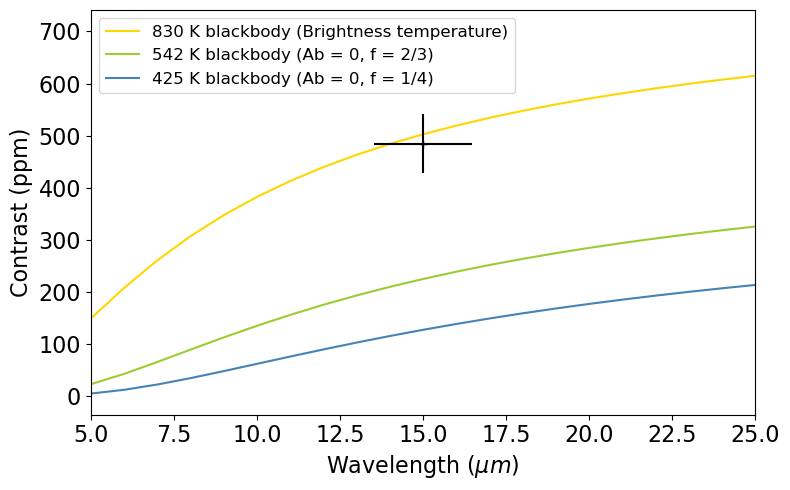

In [114]:
# blackbody ratio graph

with quantity_support():
    plt.figure(figsize=(8, 5))
    #plt.plot()
    plt.plot(wav, 0.05486**2*(flux_bright / flux_s)*1e6, label = '%3.f K blackbody (Brightness temperature)' %t_bright, color = 'gold')
    plt.plot(wav, 0.05486**2*(flux_n / flux_s)*1e6, label = '542 K blackbody (Ab = 0, f = 2/3)', color = 'yellowgreen')    
    plt.plot(wav, 0.05486**2*(flux_c / flux_s)*1e6, label = '425 K blackbody (Ab = 0, f = 1/4)', color = 'steelblue') 
    plt.errorbar(15, fp, yerr=5.6570096147929606e-05*1e6, xerr = 2.92/2, fmt='+', color='k')
    plt.ylabel('Contrast (ppm)', fontsize=16)
    plt.xlabel('Wavelength '+r'$(\mu m)$', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=12)
    #plt.ylim(0, 5000)
    plt.xlim(5, 25)
    plt.tight_layout()
    plt.gcf().patch.set_facecolor('None')
    plt.savefig('MCMC_nogp_results/blackbody_ratio.png')
    plt.show()

**Plots for presentation**

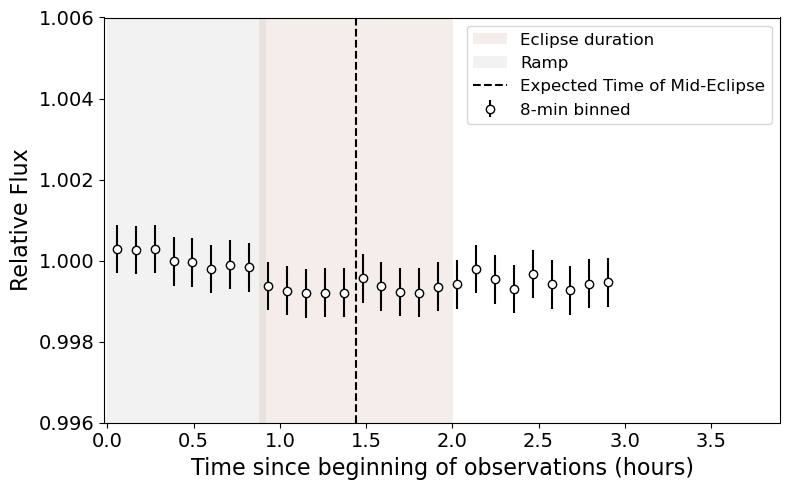

In [276]:
derived = p0_mcmc[0]
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
eclipse = eclipse.mjd
e_dur = 1.13 # hours
e_dur_days = 1.13 / 24
start = eclipse - (e_dur_days / 2)  # Center the rectangle at the start of the eclipse
error = np.sqrt(np.sum(aperr**2))/(len(time)/(nbin))
plt.figure(figsize=(8,5))

rect1 = patches.Rectangle(((eclipse-time[0])*(24)-1.13/2, 0.995), 1.13, 0.015, linewidth=1, edgecolor='None', facecolor='sienna', alpha=0.1, label='Eclipse duration')
rect2 = patches.Rectangle((0, 0.995), 55/60, 0.015, linewidth=1, edgecolor='None', facecolor='grey', alpha=0.1, label='Ramp')

plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.axvline(x=(eclipse-time[0])*(24), color='k', linestyle='--', label='Expected Time of Mid-Eclipse')

plt.errorbar((time-time[0])*(24), aplev, yerr=aperr, color='darkorange',markersize=2, alpha=0.3, fmt='o')
plt.errorbar((bins_time-time[0])*(24), bins_aplev, yerr=error, fmt='o', color='black', markeredgecolor='black', markerfacecolor='white', label = '8-min binned')

#plt.axvline(x=(derived-time[0])*(24), color='g', linestyle='-.', label='Derived Eclipse')
plt.xlabel('Time since beginning of observations (hours)', fontsize=16)
plt.ylabel('Relative Flux', fontsize=16)
plt.ylim(0.996, 1.006)
plt.xlim(-0.02, 3.9)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
# set background color to transparent
plt.gcf().patch.set_facecolor('None')
plt.savefig('figs/LHS1140_c_raw_more.pdf')

In [233]:
error = np.sqrt(np.sum(bins_aperr**2)/(len(aperr)/nbin))
print(error)

0.0005171629851978819


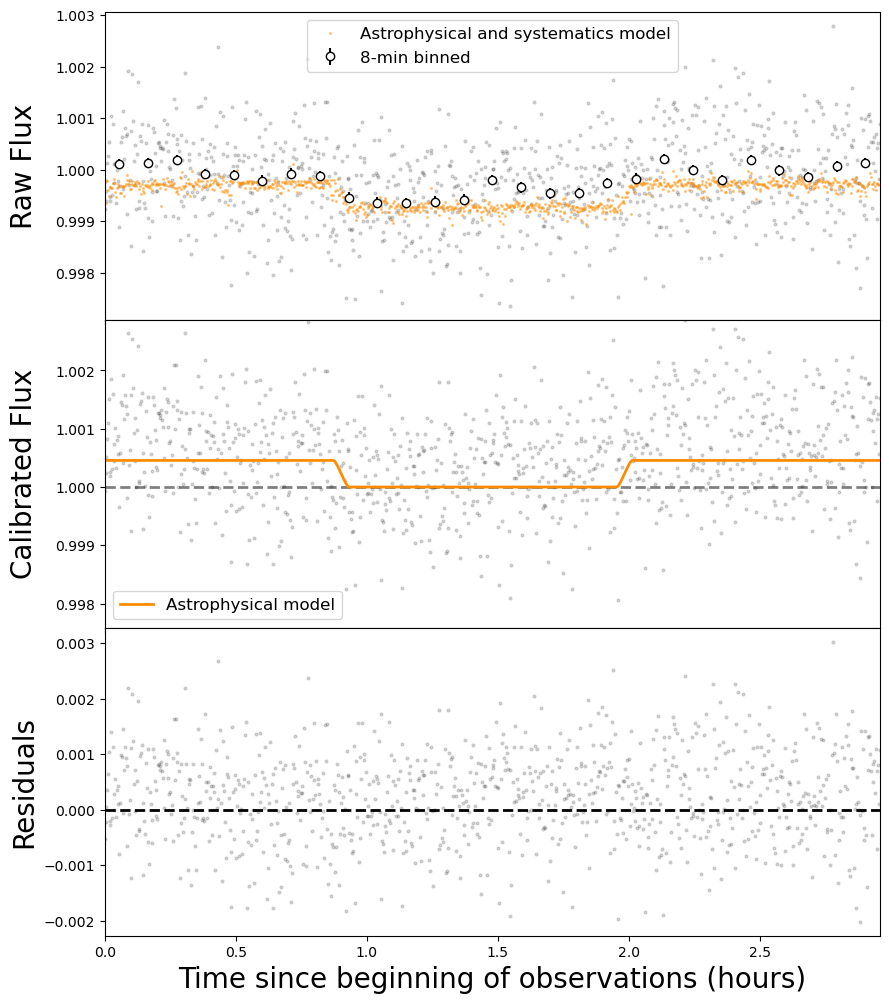

In [36]:
def plot_bestfit(time, flux, aperr, astro, detec, bins_time, bins_aplev, showPlot=True, fontsize=24):
    
    x = (time-time[0])*(24)
    nbin = 28
    bins_time, binErr_t = binValues(x, x, nbin)
    bins_aplev, binErr_aplev = binValues(flux, x, nbin)
    bins_aperr, binErr_aperr = binValues(aperr, x, nbin)
    error = np.sqrt(np.sum(bins_aperr**2))/(len(time)/nbin)
    #error = np.sqrt(np.sum(aperr**2))/(len(time)/(nbin))
    fig, axes = plt.subplots(ncols = 1, nrows = 3, sharex = True, figsize=(10, 12))
    
    axes[0].set_xlim(np.nanmin(x), np.nanmax(x))
    axes[0].errorbar(bins_time, bins_aplev, yerr=error, fmt='o', color='black', markeredgecolor='black', markerfacecolor='white', label = '8-min binned')
    axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[0].plot(x, astro*detec, '.', color = 'darkorange', markersize = 2.5, alpha = 0.4, label = 'Astrophysical and systematics model')
    axes[0].set_ylabel('Raw Flux', fontsize=fontsize)
    axes[0].legend(fontsize=12)
    
    axes[1].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
    axes[1].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[1].plot(x, astro, color = 'darkorange', linewidth=2, label = 'Astrophysical model')
    axes[1].legend(fontsize=12)

    axes[1].set_ylabel('Calibrated Flux', fontsize=fontsize)
    axes[1].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))

    axes[2].plot(x, flux/detec - astro, 'k.', markersize = 4, alpha = 0.15)
    axes[2].axhline(y=0, color='black', linestyle = '--', linewidth = 2)

    axes[2].set_ylabel('Residuals', fontsize=fontsize)
    axes[2].set_xlabel('Time since beginning of observations (hours)', fontsize=fontsize)

    
    fig.align_ylabels()
    fig.subplots_adjust(hspace=0)
    plt.gcf().patch.set_facecolor('None')
    fig.savefig('MCMC_nogp_results/best_fit_final_plot.png')
        
    if showPlot:
        plt.show()
    
    plt.close()
    return

t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
plot_bestfit(time, aplev/linear_slope(time, a, b), aperr, astro, detec, bins_time, bins_aplev, showPlot=True, fontsize=20)

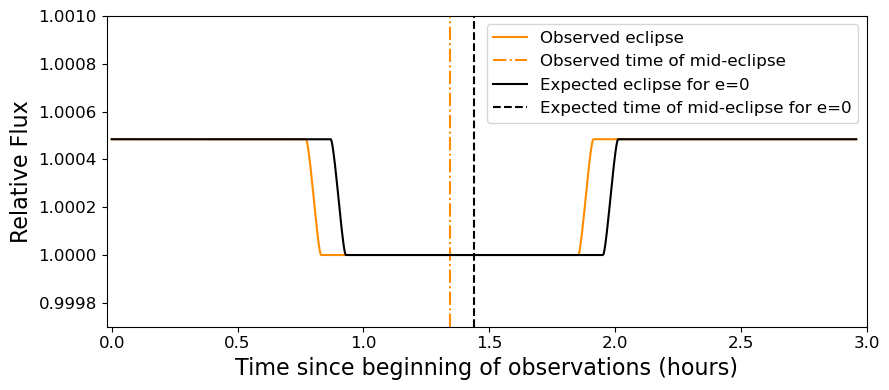

In [98]:
# plot eccentricity comparison
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
expected = transit_model(time, 60275.875, fp)

plt.figure(figsize=(9,4))
plt.plot((time-time[0])*24, astro, '-', label = 'Observed eclipse', color = 'darkorange')#,alpha=0.3, markersize=3)
plt.axvline(x=(t_s-time[0])*24, color='darkorange', linestyle='-.', label='Observed time of mid-eclipse')
plt.plot((time-time[0])*24, expected, label = 'Expected eclipse for e=0', color = 'k')
plt.axvline(x=(60275.875-time[0])*24, color='k', linestyle='--', label='Expected time of mid-eclipse for e=0')
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time since beginning of observations (hours)', fontsize=16)
plt.ylabel('Relative Flux', fontsize=16)
plt.ylim(0.9997, 1.001)
plt.xlim(-0.02, 3)
plt.ticklabel_format(axis='y', style='plain',useOffset=False)
# remove scientific notation
plt.tick_params(axis='both', which='major', labelsize=12)
# remove background color
plt.gcf().patch.set_facecolor('None')
plt.tight_layout()
plt.savefig('figs/LHS1140_c_eccentricity.pdf')
plt.show()
plt.close()

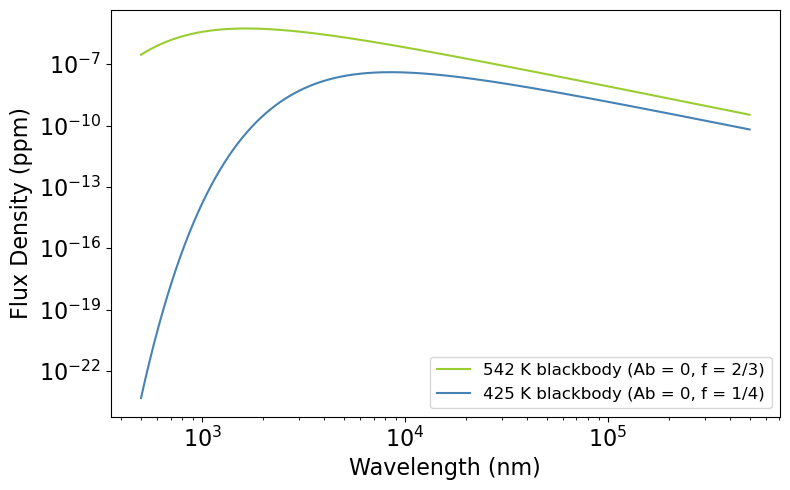

In [169]:
# blackbody comparison
t_star = 3096 #3216 
A_b = 0.0
a = 26.57 # ratio a/t_s
f = 2/3 # heat redistribution #2/3 # no heat redristribution

#fp = p0[1]
t_eq_n = t_star * np.sqrt(1/a) * (2/3*(1 - A_b)) ** 0.25 

wav = np.arange(500, 500000) * u.nm

bb_s = BlackBody(temperature=t_star*u.K)
bb_n = BlackBody(temperature=600*u.K)

flux_s = bb_s(wav)
flux_n = bb_n(wav)

with quantity_support():
    plt.figure(figsize=(8, 5))
    #plt.plot()
    plt.plot(wav, (flux_s), label = '542 K blackbody (Ab = 0, f = 2/3)', color = 'yellowgreen')    
    plt.plot(wav, (flux_n), label = '425 K blackbody (Ab = 0, f = 1/4)', color = 'steelblue') 
    # log x axis
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Flux Density (ppm)', fontsize=16)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=12)
    #plt.ylim(0, 5000)
    #plt.xlim(0, 50)
    plt.tight_layout()
    plt.gcf().patch.set_facecolor('None')
    plt.savefig('MCMC_nogp_results/blackbody_ratio.png')
    plt.show()

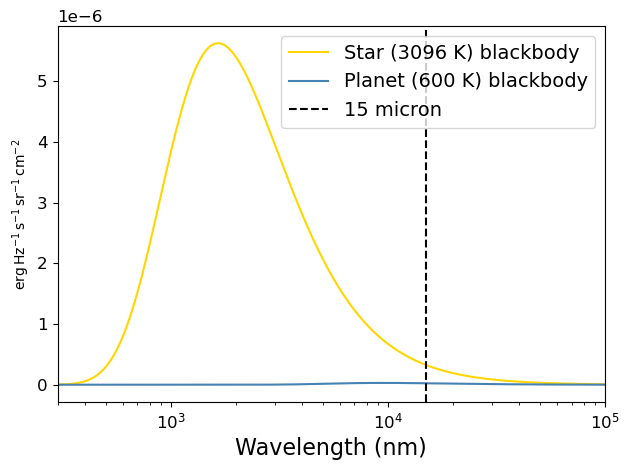

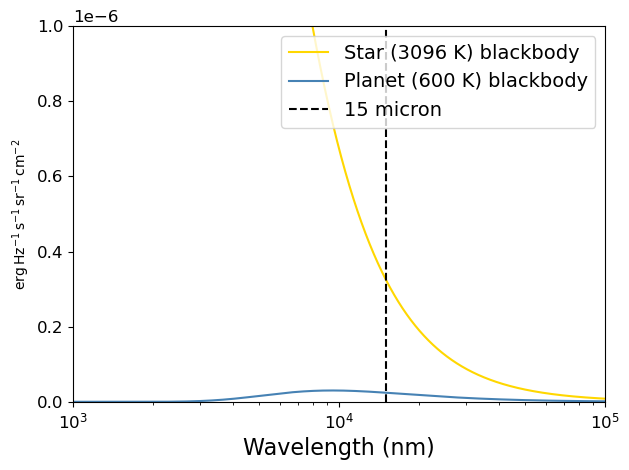

In [210]:
bb1 = BlackBody(temperature=t_star*u.K)
bb2 = BlackBody(temperature=542*u.K)
wav = np.arange(100, 110000) * u.nm
flux1 = bb1(wav)
flux2 = bb2(wav)

with quantity_support():
    plt.figure()
    plt.semilogx(wav, flux1, color='gold', label='Star (3096 K) blackbody')
    plt.semilogx(wav, flux2, color='steelblue', label='Planet (600 K) blackbody')
    plt.axvline(15000, color='k', linestyle='--', label='15 micron')
    plt.legend(fontsize=14)
    #plt.axvline(bb.nu_max.to(u.AA, equivalencies=u.spectral()).value, ls='--')
    #plt.ylim(0, 1e-5)
    plt.xlim(3e2, 1e5)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.gcf().patch.set_facecolor('None')
    plt.tight_layout()
    plt.savefig('figs/blackbody_comparison1.png')
    plt.show()

    plt.figure()
    plt.semilogx(wav, flux1, color='gold', label='Star (3096 K) blackbody')
    plt.semilogx(wav, flux2, color='steelblue', label='Planet (600 K) blackbody')
    plt.axvline(15000, color='k', linestyle='--', label='15 micron')
    plt.ylim(0, 1e-6)
    plt.xlim(1e3, 1e5)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.legend(fontsize=14)
    plt.gcf().patch.set_facecolor('None')
    plt.tight_layout()
    plt.savefig('figs/blackbody_comparison2.png')
    plt.show()